# ImageNet Analyze different methods

This notebook illustrates the effect of the proposed methods on some recent networks. We compare the results based on a single image.

## Imports

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imp
import time
import sys
import os
import argparse

import keras.backend
import keras.models

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.tests.networks.imagenet
import innvestigate.utils.visualizations as ivis

eutils = imp.load_source("utils", "../utils.py")
imgnetutils = imp.load_source("utils_imagenet", "../utils_imagenet.py")

Using TensorFlow backend.


# Choose & load image

This analysis is based on a single test image of the ones stored in `examples/images`. Other example images can be used by loading these into the above folder.

In [3]:
# Choose the number of an image in the example folder (between 0-6)
image_n = 3

# Load image from example folder
images, label_to_class_name = eutils.get_imagenet_data()[:2]
images = images[image_n]
label_to_class_name = label_to_class_name[image_n]

# Choose & load models

A full list of available models is available at `/innvestigate/applications/imagenet.py`.

In [4]:
# Choose a list of models
netnames = ["vgg16",
            "resnet50"]

n_nets = len(netnames)

# Analysis

In [ ]:
pattern_type = "relu"
channels_first = keras.backend.image_data_format == "channels_first"
analysis_all = []

for i, netname in enumerate(netnames):
    print("Analyse {}.".format(netname))
    
    # Build model.
    tmp = getattr(innvestigate.applications.imagenet, netname)
    net = tmp(load_weights=True, load_patterns=pattern_type)
    model = keras.models.Model(inputs=net["in"], outputs=net["out"])
    model.compile(optimizer="adam", loss="categorical_crossentropy")
    modelp = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
    modelp.compile(optimizer="adam", loss="categorical_crossentropy")
    
    color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None

    # Analysis.
    patterns = net["patterns"]
        
    methods = [
        # NAME             POSTPROCESSING     TITLE

        # Show input.
        ("input",                 {},                            imgnetutils.image,   "Input"),

        # Function
        ("gradient",              {},                            imgnetutils.graymap, "Gradient"),
        ("integrated_gradients",  {},                            imgnetutils.graymap, ("Integrated", "Gradients")),

        # Signal
        ("deconvnet",             {},                            imgnetutils.bk_proj, "Deconvnet"),
        ("guided_backprop",       {},                            imgnetutils.bk_proj, ("Guided", "Backprop"),),
        ("pattern.net",           {"patterns": patterns},        imgnetutils.bk_proj, "PatterNet"),

        # Interaction
        ("pattern.attribution",   {"patterns": patterns},        imgnetutils.heatmap, ("Pattern", "Attribution"),),
        ("lrp.epsilon",           {},                            imgnetutils.heatmap, "LRP Epsilon"),
        ("lrp.composite_a",       {},                            imgnetutils.heatmap, "LRP CompositeA"),
        ("lrp.composite_b",       {},                            imgnetutils.heatmap, "LRP CompositeB")
    ]

    # Create analyzers.
    analyzers = []
    for method in methods:
        try:
            analyzer = innvestigate.create_analyzer(method[0],
                                                      model,
                                                      **method[1])
        except innvestigate.NotAnalyzeableModelException:
            analyzer = None
        analyzers.append(analyzer)

    # Create analysis.
    analysis = np.zeros([len(analyzers)] + net["image_shape"] + [3])

    image,y = images
    image = image[None, :, :, :]
    # Predict label.
    x = imgnetutils.preprocess(image, net)
    presm = model.predict_on_batch(x)[0]
    prob = modelp.predict_on_batch(x)[0]
    y_hat = prob.argmax()

    for aidx, analyzer in enumerate(analyzers):
        # Measure execution time
        t_start = time.time()
        print('{} '.format(''.join(methods[aidx][-1])), end='', flush=True)
        
        is_input_analyzer = methods[aidx][0] == "input"
        # Analyze.
        if analyzer != None:
            a = analyzer.analyze(image if is_input_analyzer else x)
        else:
            print("Analyzer not available for this model.")
        
        t_elapsed = time.time() - t_start
        print('({:.4f}s) '.format(t_elapsed), end='', flush=True)
        
        # Postprocess.
        if not np.all(np.isfinite(a)):
            print("Image %i, analysis of %s not finite: nan %s inf %s" %
                  (i, methods[aidx][3],
                   np.any(np.isnan(a)), np.any(np.isinf(a))))
        if not is_input_analyzer:
            a = imgnetutils.postprocess(a, color_conversion, channels_first)
        a = methods[aidx][2](a)
        analysis[aidx] = a[0]
        
        if analyzer != None:
            print('Finished analysis of {}'.format(''.join(methods[aidx][-1])))
    
    # Clear session.
    keras.backend.clear_session()
    
    analysis_all.append(analysis)

Analyse vgg16.
Input (0.0242s) Finished analysis of Input
Gradient (1.7495s) Finished analysis of Gradient
IntegratedGradients 

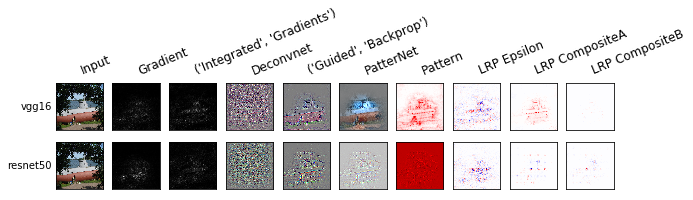

In [7]:
# Plot the analysis.
grid = [[analysis_all[i][j] for j in range(len(methods))]
        for i in range(n_nets)]
row_labels = netnames
col_labels = [method[3] for method in methods]

n_rows = len(grid)
n_cols = len(grid[0])
shape_per_image = grid[0][0].shape[:2]
n_padding = shape_per_image[0]//5
shape_per_image_padded = [s + 2 * n_padding for s in shape_per_image]
fontsize = 10

plt.figure(figsize = (n_cols, n_rows))
for r in range(n_rows):
    for c in range(n_cols):
        ax = plt.subplot2grid(shape=[n_rows, n_cols], loc=[r,c])
        ax.imshow(grid[r][c], interpolation='none') 
        ax.set_xticks([])
        ax.set_yticks([])

        if not r: #method names
            ax.set_title(col_labels[c],
                         rotation=22.5,
                         horizontalalignment='left',
                         verticalalignment='bottom')
        if not c: #network names
            ax.set_ylabel(row_labels[r],
                          rotation=0,
                          verticalalignment='center',
                          horizontalalignment='right')
plt.show()